In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
dataset_path = os.listdir("/content/drive/MyDrive/keb/data")
if ".DS_Store" in dataset_path:
  dataset_path.remove(".DS_Store")
print(dataset_path)


rooms = []

for item in dataset_path:
  all_rooms = os.listdir("/content/drive/MyDrive/keb/data"+"/"+item) #각 폴더에 들어갈 데이터의 이름들 가져오기.
  print("items : ",len(all_rooms))
  for room in all_rooms:
    #tag,이름
    rooms.append((item, str("/content/drive/MyDrive/keb/data"+"/"+item)+"/"+room))


train_df = pd.DataFrame(data=rooms, columns =["tag", "video_name"])


df = train_df.loc[:,["video_name", "tag"]]
df.to_csv("data_test.csv")

data = pd.read_csv("data_test.csv")
print(data.head())
print(data.tail())
print("")
data["tag"] = data["tag"].map({"폭력": 1, "정상": 0})


data = data[["video_name","tag"]]
print(data.tail())

#train, valid, test로 만들어야함.

train_ = data.sample(frac=0.8, random_state=42)
tmp = data.drop(train_.index)
valid = tmp.sample(frac=0.5, random_state=42)
test = tmp.drop(valid.index)


train_.to_csv("/content/drive/MyDrive/keb/train_test.csv")
valid.to_csv("/content/drive/MyDrive/keb/valid_test.csv")
test.to_csv("/content/drive/MyDrive/keb/test_test.csv")

['폭력', '정상']
items :  642
items :  304
   Unnamed: 0                                         video_name     tag
0           0  /content/drive/MyDrive/keb/data/폭력/C_3_13_...  폭력
1           1  /content/drive/MyDrive/keb/data/폭력/C_3_13_...  폭력
2           2  /content/drive/MyDrive/keb/data/폭력/C_3_13_...  폭력
3           3  /content/drive/MyDrive/keb/data/폭력/C_3_13_...  폭력
4           4  /content/drive/MyDrive/keb/data/폭력/C_3_13_...  폭력
     Unnamed: 0                                         video_name     tag
941         941  /content/drive/MyDrive/keb/data/정상/C_2_4_4...  정상
942         942  /content/drive/MyDrive/keb/data/정상/C_2_4_8...  정상
943         943  /content/drive/MyDrive/keb/data/정상/C_2_4_8...  정상
944         944  /content/drive/MyDrive/keb/data/정상/C_2_4_5...  정상
945         945  /content/drive/MyDrive/keb/data/정상/C_2_4_4...  정상

                                            video_name  tag
941 

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/keb/train_test.csv")
test = pd.read_csv("/content/drive/MyDrive/keb/test_test.csv")
valid = pd.read_csv("/content/drive/MyDrive/keb/valid_test.csv")

In [ ]:
train.head()

,Unnamed: 0,video_name,tag
0,327,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
1,30,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
2,820,/content/drive/MyDrive/keb/data/정상/C_2_4_7...,0
3,404,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
4,76,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1


In [ ]:
print(len(train))
print(len(valid))
print(len(test))

757
94
95


In [ ]:
train.head()

,Unnamed: 0,video_name,tag
0,327,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
1,30,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
2,820,/content/drive/MyDrive/keb/data/정상/C_2_4_7...,0
3,404,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
4,76,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1


In [ ]:
valid.iloc[40:55]

,Unnamed: 0,video_name,tag
40,510,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
41,389,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
42,474,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
43,345,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
44,130,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
45,646,/content/drive/MyDrive/keb/data/정상/C_2_4_6...,0
46,801,/content/drive/MyDrive/keb/data/정상/C_2_4_4...,0
47,270,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
48,138,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1
49,52,/content/drive/MyDrive/keb/data/폭력/C_3_13_...,1


In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, video_path_list,label_list):
    self.video_path_list = video_path_list
    self.label_list = label_list

  def __getitem__(self, index):
    frames = self.get_video(self.video_path_list[index])
    if self.label_list is not None:
      label = self.label_list[index]
      return frames, label
    else:
      return frames

  def __len__(self):
    return len(self.video_path_list)

  def get_video(self, path):
    frames = []
    cap = cv2.VideoCapture(path)
    for _ in range(47):
      _, img = cap.read()

      if img is not None:
        img = cv2.resize(img, (128,128))
        img = img/255
        frames.append(img)

    cap.release()

    # return torch.FloatTensor(np.array(frames)).permute(3,0,1,2)

    return torch.FloatTensor(np.array(frames)).permute(0,3,1,2)

  def check_frame(self, frames):
    return frames.shape

In [ ]:
train_dataset = CustomDataset(train["video_name"].values, train["tag"].values)
print(train_dataset[0][0].size()) #[데이터수, 채널, 프레임수, 크기,크기]
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataset = CustomDataset(valid["video_name"].values, valid["tag"].values)
val_loader = DataLoader(val_dataset, batch_size =4, shuffle=False, num_workers=0)

torch.Size([47, 3, 128, 128])


In [ ]:
from torchvision.models import resnet101

class CNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNLSTM, self).__init__()
        self.resnet = resnet101(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x_3d):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t])
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

        # Get the last hidden state (hidden is a tuple with both hidden and cell state in it)
        x = self.fc1(hidden[0][-1])
        x = F.relu(x)
        x = self.fc2(x)

        return x




In [ ]:
def validation(model, criterion, val_loader, device):
  model.eval()
  val_loss = []
  preds, trues = [],[]

  with torch.no_grad():
    for videos, labels in tqdm(iter(val_loader)):
      videos = videos.to(device)
      labels = labels.to(device)
      print(labels)

      logit = model(videos)

      loss = criterion(logit, labels)
      val_loss.append(loss.item())

      preds +=logit.argmax(1).detach().cpu().numpy().tolist()
      trues += labels.detach().cpu().numpy().tolist()

    _val_loss = np.mean(val_loss)

  _val_score = f1_score(trues, preds, average="macro")
  return _val_loss, _val_score

In [ ]:
def train_(model, optimizer, train_loader, val_loader, schedule, device):
  model.to(device)
  criterion = nn.CrossEntropyLoss().to(device)

  best_val_score = 0
  best_model = None
  all_train_loss = {}
  all_val_loss = {}
  for epoch in range(1,21): #테스트 용이니까.
    model.train()
    train_loss=[]
    for videos, labels in tqdm(iter(train_loader)):
      videos = videos.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      output = model(videos)

      loss = criterion(output, labels)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    _val_loss, _val_score = validation(model, criterion, val_loader, device)
    _train_loss = np.mean(train_loss)
    all_train_loss[epoch] = _train_loss
    all_val_loss[epoch] = _val_loss
    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')

    if schedule is not None:
      schedule.step(_val_score)

    if best_val_score < _val_score:
      best_val_score = _val_score
      best_model = model

  return all_train_loss, all_val_loss,best_model

In [ ]:
model = CNNLSTM()
# model = CRNN()

model.eval()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, threshold_mode="abs",
                                                      min_lr=1e-8, verbose=True)
all_train_loss, all_val_loss, infer_model = train_(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [1], Train Loss : [0.68613] Val Loss : [0.63402] Val F1 : [0.40506]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [2], Train Loss : [0.62869] Val Loss : [0.63122] Val F1 : [0.40506]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [3], Train Loss : [0.62895] Val Loss : [0.64262] Val F1 : [0.40506]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [4], Train Loss : [0.63479] Val Loss : [0.62950] Val F1 : [0.40506]
Epoch 00004: reducin

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [5], Train Loss : [0.62658] Val Loss : [0.62905] Val F1 : [0.40506]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [6], Train Loss : [0.62514] Val Loss : [0.63439] Val F1 : [0.40506]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [7], Train Loss : [0.62759] Val Loss : [0.62893] Val F1 : [0.40506]
Epoch 00007: reducin

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [8], Train Loss : [0.62422] Val Loss : [0.62025] Val F1 : [0.40506]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [9], Train Loss : [0.61787] Val Loss : [0.64306] Val F1 : [0.40506]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [10], Train Loss : [0.62765] Val Loss : [0.61569] Val F1 : [0.40506]
Epoch 00010: reduci

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [11], Train Loss : [0.54981] Val Loss : [0.67175] Val F1 : [0.40506]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [12], Train Loss : [0.50032] Val Loss : [0.64773] Val F1 : [0.47276]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [13], Train Loss : [0.42064] Val Loss : [0.82428] Val F1 : [0.37848]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [14], Train Loss : [0.36089] Val Loss : [0.74434] Val F1 : [0.40506]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [15], Train Loss : [0.39225] Val Loss : [0.43945] Val F1 : [0.74657]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [16], Train Loss : [0.34506] Val Loss : [0.77264] Val F1 : [0.54770]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [17], Train Loss : [0.29961] Val Loss : [0.77201] Val F1 : [0.49613]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [18], Train Loss : [0.32346] Val Loss : [0.68106] Val F1 : [0.62097]
Epoch 00018: reduci

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [19], Train Loss : [0.28185] Val Loss : [0.69021] Val F1 : [0.62751]


  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

tensor([0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0], device='cuda:0')
tensor([1, 1, 0, 1], device='cuda:0')
tensor([0, 1, 0, 1], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([1, 1, 0, 0], device='cuda:0')
tensor([1, 0, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')
Epoch [20], Train Loss : [0.25101] Val Loss : [0.76353] Val F1 : [0.57889]


In [ ]:
print(all_train_loss)
print(all_val_loss)

{1: 0.6861327204265093, 2: 0.6286903230767501, 3: 0.6289463490247726, 4: 0.6347894827001973, 5: 0.6265815650161944, 6: 0.6251357848706999, 7: 0.6275900189813814, 8: 0.6242230327505814, 9: 0.6178675933103812, 10: 0.6276543828217607, 11: 0.5498092071006172, 12: 0.5003174651218089, 13: 0.420635397810685, 14: 0.36089027049510103, 15: 0.39224638746757257, 16: 0.3450629466066235, 17: 0.2996140475924078, 18: 0.32345737191407303, 19: 0.2818548816403276, 20: 0.2510069798089956}
{1: 0.6340226220587889, 2: 0.6312191834052404, 3: 0.642622634768486, 4: 0.6295033395290375, 5: 0.6290527582168579, 6: 0.6343900312980016, 7: 0.6289273301760355, 8: 0.620253898203373, 9: 0.6430597255627314, 10: 0.615693237632513, 11: 0.671753853559494, 12: 0.6477264532198509, 13: 0.8242805774013201, 14: 0.7443351584176222, 15: 0.4394542674223582, 16: 0.772641793359071, 17: 0.7720058808724085, 18: 0.6810575518757105, 19: 0.6902066124603152, 20: 0.7635331978090107}


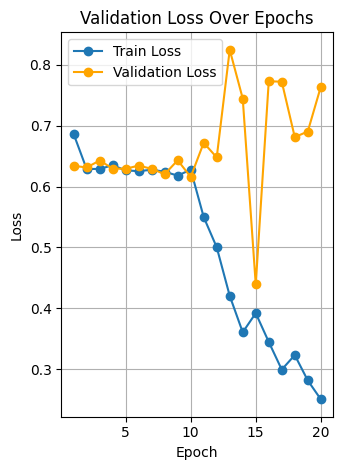

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(list(all_train_loss.keys()), list(all_train_loss.values()), marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)

# 두 번째 subplot에 검증 손실 값을 그래프로 그립니다.
plt.subplot(1, 2, 1)
plt.plot(list(all_val_loss.keys()), list(all_val_loss.values()), marker='o', label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()  # subplot 간 간격을 조절합니다.
plt.show()

In [ ]:
test_dataset = CustomDataset(test['video_name'].values, None)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for videos in tqdm(iter(test_loader)):
            videos = videos.to(device)
            print(videos)

            logit = model(videos)

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
    return preds

In [ ]:
preds = inference(model, test_loader, device)

In [ ]:
print(preds)

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


In [ ]:
test["tag"]

0     1
1     1
2     1
3     1
4     1
     ..
90    0
91    0
92    0
93    0
94    0
Name: tag, Length: 95, dtype: int64

In [ ]:
print(list(test["tag"]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
t = list(test["tag"])
print(t)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
i = 0
for x,y in zip(t, preds):
  if x==y:
    print("성공")
  else:
    i+=1
    print("실패")

print(i/len(preds))


In [ ]:
import cv2
import numpy as np
import os
import torch

def get_video(path):
    frames = []
    cap = cv2.VideoCapture(path)
    for _ in range(47):
      _, img = cap.read()

      if img is not None:
        img = cv2.resize(img, (128,128))
        img = img/255
        frames.append(img)

    cap.release()

    return torch.FloatTensor(np.array(frames)).permute(0,3,1,2).unsqueeze(0)

def predict_video(video_path):
    print("flag")
    video_tensor = get_video(video_path)
    video_tensor = video_tensor.to(device)

    with torch.no_grad():
        output = model(video_tensor)
        prediction = torch.argmax(output, dim=1).item()
    return "폭력" if prediction == 1 else "정상"

content_path = "/content/drive/MyDrive/keb/test_Violence"
video_files = [f for f in os.listdir(content_path) if f.endswith('.mp4')]
print(video_files)

total = 0
correct = 0
incorrect = []
for video_file in video_files:
    total +=1
    video_path = os.path.join(content_path, video_file)
    tmp = "/content/drive/MyDrive/keb/test_Violence/"
    video_file = tmp+video_file
    print(video_file)
    prediction_result = predict_video(video_path)
    if prediction_result == "폭력":
      i +=1
    else:
      incorrect.append(video_file)

    print(f"영상 이름: {video_file}, 분류: {prediction_result}")

print(i/total)

In [ ]:
for i in sorted(incorrect):
  print(i)

/content/drive/MyDrive/keb/test_Violence/V_1000.mp4
/content/drive/MyDrive/keb/test_Violence/V_116.mp4
/content/drive/MyDrive/keb/test_Violence/V_127.mp4
/content/drive/MyDrive/keb/test_Violence/V_131.mp4
/content/drive/MyDrive/keb/test_Violence/V_136.mp4
/content/drive/MyDrive/keb/test_Violence/V_137.mp4
/content/drive/MyDrive/keb/test_Violence/V_142.mp4
/content/drive/MyDrive/keb/test_Violence/V_147.mp4
/content/drive/MyDrive/keb/test_Violence/V_149.mp4
/content/drive/MyDrive/keb/test_Violence/V_150.mp4
/content/drive/MyDrive/keb/test_Violence/V_152.mp4
/content/drive/MyDrive/keb/test_Violence/V_154.mp4
/content/drive/MyDrive/keb/test_Violence/V_162.mp4
/content/drive/MyDrive/keb/test_Violence/V_183.mp4
/content/drive/MyDrive/keb/test_Violence/V_184.mp4
/content/drive/MyDrive/keb/test_Violence/V_185.mp4
/content/drive/MyDrive/keb/test_Violence/V_186.mp4
/content/drive/MyDrive/keb/test_Violence/V_193.mp4
/content/drive/MyDrive/keb/test_Violence/V_194.mp4
/content/drive/MyDrive/keb/tes